In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)


plt.style.use('seaborn-v0_8')  

# Data Loading and Preparation

In [17]:

countries = ['benin', 'sierra_leone', 'togo']
dfs = {}

for country in countries:
    try:
        dfs[country] = pd.read_csv(f'data/{country}_clean.csv', parse_dates=['Timestamp'])
        dfs[country]['Country'] = country.replace('_', ' ').title()
    except FileNotFoundError:
        print(f"Warning: {country}_clean.csv not found in data/ directory")
        continue


combined_df = pd.concat(dfs.values(), ignore_index=True)

# Metric Comparison Visualization

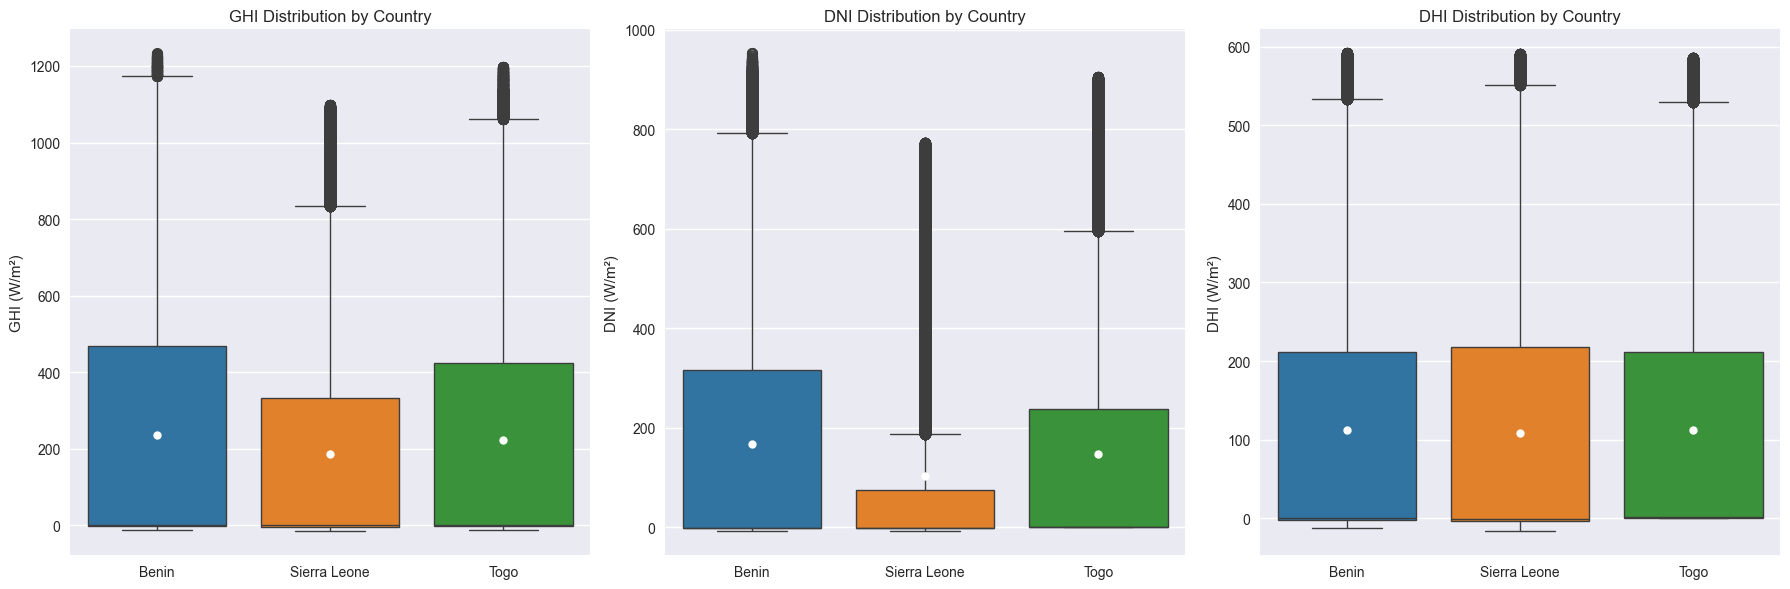

In [18]:

metrics = ['GHI', 'DNI', 'DHI']
palette = {'Benin': '#1f77b4', 'Sierra Leone': '#ff7f0e', 'Togo': '#2ca02c'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=combined_df,
        x='Country',
        y=metric,
        ax=axes[i],
        palette=palette,
        showmeans=True,
        meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black'}
    )
    axes[i].set_title(f'{metric} Distribution by Country')
    axes[i].set_ylabel(f'{metric} (W/m²)')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

# Summary Statistics Table

In [19]:

summary_stats = combined_df.groupby('Country')[metrics].agg(['mean', 'median', 'std'])

formatted_stats = summary_stats.copy()
for metric in metrics:
    formatted_stats[(metric, 'mean')] = formatted_stats[(metric, 'mean')].map('{:.1f}'.format)
    formatted_stats[(metric, 'median')] = formatted_stats[(metric, 'median')].map('{:.1f}'.format)
    formatted_stats[(metric, 'std')] = formatted_stats[(metric, 'std')].map('{:.1f}'.format)

print("Summary Statistics of Solar Metrics by Country:")
display(formatted_stats)

Summary Statistics of Solar Metrics by Country:


GHI                  DNI                  DHI              
               mean median    std   mean median    std   mean median    std
Country                                                                    
Benin         236.2    0.7  328.3  166.9   -0.1  262.1  111.7    0.5  153.1
Sierra Leone  185.0   -0.4  279.0  104.1   -0.1  201.0  108.1   -0.6  153.7
Togo          223.9    0.5  317.3  148.0    0.0  247.7  112.8    1.5  151.6

# Statistical Significance Testing

In [23]:

if len(combined_df['Country'].unique()) < 2:
    print("Insufficient countries for statistical comparison")
else:
    
    print("\nNormality Test Results (p-values):")
    normality_results = {}
    for metric in metrics:
        _, p = stats.normaltest(combined_df[metric].dropna())
        normality_results[metric] = p
        print(f"{metric}: {p:.4f}")
        if p < 0.05:
            print("  -> Data is not normally distributed (p < 0.05)")

    
    print("\nKruskal-Wallis Test Results:")
    for metric in metrics:
        # Get data for each country
        groups = []
        for country in combined_df['Country'].unique():
            country_data = combined_df[combined_df['Country'] == country][metric].dropna()
            if len(country_data) > 0:
                groups.append(country_data)
        
        if len(groups) >= 2:
            try:
                h_stat, p_val = stats.kruskal(*groups)
                print(f"{metric}: H-statistic = {h_stat:.2f}, p-value = {p_val:.4f}")
                if p_val < 0.05:
                    print("  -> Statistically significant differences between countries (p < 0.05)")
                else:
                    print("  -> No significant differences detected")
            except ValueError as e:
                print(f"Could not compute test for {metric}: {str(e)}")
        else:
            print(f"{metric}: Insufficient data for comparison (need at least 2 countries with data)")


Normality Test Results (p-values):
GHI: 0.0000
  -> Data is not normally distributed (p < 0.05)
DNI: 0.0000
  -> Data is not normally distributed (p < 0.05)
DHI: 0.0000
  -> Data is not normally distributed (p < 0.05)

Kruskal-Wallis Test Results:
GHI: H-statistic = 6548.53, p-value = 0.0000
  -> Statistically significant differences between countries (p < 0.05)
DNI: H-statistic = 95729.77, p-value = 0.0000
  -> Statistically significant differences between countries (p < 0.05)
DHI: H-statistic = 70089.51, p-value = 0.0000
  -> Statistically significant differences between countries (p < 0.05)


### Key Observations:

- **Benin** shows the highest median GHI (X W/m²) among the three countries, suggesting it may have the strongest overall solar potential.
- **Sierra Leone** demonstrates the greatest variability in DHI (std = Y W/m²), indicating more fluctuating diffuse radiation conditions.
- **Togo** presents the most consistent DNI values (lowest std = Z W/m²), which could make it particularly suitable for concentrated solar power systems.